# Research Question 3: Logistic Regression

Here, we build a simple logistic regression model to classify hotel reviews
into two basic categories: those with negative and those with positive sentiment.

In [71]:
%matplotlib inline

from ipykernel import get_connection_file
import os

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="paper")  # , font="serif")


# natural language processing
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string

# machine learning imports
from funcsigs import signature
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [72]:
# import the data
DATADIR = os.path.join(
    os.path.abspath(os.path.dirname("")), "../data"
)
DF = pd.read_csv(
    os.path.join(DATADIR, "combined_sentiments.csv"),
    header=0,
    sep=",",
    on_bad_lines="skip",
)
STOP = stopwords.words("english")


# lemmatise
def get_wordnet_pos(pos_tag):
    """lemmatises words by classifying them into their
    respective parts of speech"""
    if pos_tag.startswith("J"):
        return wordnet.ADJ
    elif pos_tag.startswith("V"):
        return wordnet.VERB
    elif pos_tag.startswith("N"):
        return wordnet.NOUN
    elif pos_tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN


def check_digits(text):
    """is there a digit in the text?"""
    return any(i.isdigit() for i in text)


def clean_review(review):
    """tokenise and clean up punctuation"""
    review = str(review).lower()
    review = [
        word.strip(string.punctuation)
        for word in review.split(" ")
    ]  # remove punctuation
    review = [
        word for word in review if not check_digits(word)
    ]  # remove digits

    # remove stop words
    review = [
        token for token in review if token not in STOP
    ]

    # remove empty tokens
    review = [token for token in review if len(token) > 0]

    # tag each token with its part of speech (pos)
    pos_tags = pos_tag(review)
    review = [
        WordNetLemmatizer().lemmatize(
            tag[0], get_wordnet_pos(tag[1])
        )
        for tag in pos_tags
    ]

    # remove words with only one letter
    review = [token for token in review if len(token) > 1]
    review = " ".join(review)
    return review


# generate a cleaned, tokenised and lemmatised version of the reviews
DF["reviews.clean"] = DF["reviews.text"].apply(clean_review)
REVIEWS_CLEAN = DF["reviews.clean"]

# get a list of all the reviews, and extract all the tokens as one big list
REVIEWS_ALL = DF["reviews.clean"].values.tolist()

# TF-IDF

Let's get the term frequency-inverse document frequencies for each token
in each review.

The **raw term frequency** for a token in a document (a review) is $\text{tf}\left(t, d\right)$,
where $t$ is a term (a token) and $d$ is a document.
The number of documents where where term $t$ appears is $\text{df}\left(t, d\right)$,
and the inverse document frequency $\text{idf}\left(t, d\right) = \log \frac{n_d}{1 + \text{df}\left(d, t\right)}$.

The TF-IDF is thus $\text{tfidf}\left(t, d\right) = \text{tf}\left(t, d\right)\text{idf}\left(t, d\right)$.

In [73]:
# create a feature vector that counts the number of times each word appears in the review
COUNT_VECTORISER = CountVectorizer()
WORDBAG = COUNT_VECTORISER.fit_transform(REVIEWS_ALL)

COUNT_VECTORISER.vocabulary_

{'experience': 4278,
 'rancho': 9515,
 'valencia': 12737,
 'absolutely': 35,
 'perfect': 8728,
 'begin': 1126,
 'end': 3970,
 'felt': 4479,
 'special': 11135,
 'happy': 5393,
 'stay': 11318,
 'would': 13391,
 'come': 2355,
 'back': 889,
 'heart': 5478,
 'beat': 1077,
 'amazing': 384,
 'place': 8904,
 'everyone': 4174,
 'extremely': 4327,
 'warm': 13044,
 'welcoming': 13148,
 'we': 13111,
 've': 12781,
 'top': 12133,
 'notch': 8085,
 'definitely': 3144,
 'great': 5203,
 'romantic': 10146,
 'getaway': 5036,
 'take': 11714,
 'kid': 6502,
 'along': 352,
 'couple': 2748,
 'stuffed': 11464,
 'animal': 465,
 'wait': 12987,
 'girl': 5057,
 'upon': 12657,
 'arrival': 639,
 'can': 1727,
 'go': 5105,
 'book': 1368,
 'night': 7980,
 'play': 8937,
 'tennis': 11847,
 'since': 10806,
 'one': 8275,
 'high': 5561,
 'rat': 9536,
 'resort': 9905,
 'america': 405,
 'really': 9576,
 'luxury': 7085,
 'standpoint': 11276,
 'overall': 8415,
 'villa': 12880,
 'staff': 11240,
 'attention': 763,
 'detail': 3286,

In [74]:
# create a tfidf transformer instance...
TFIDF_TRANSFORM = TfidfTransformer(
    use_idf=True,
    norm="l2",
    smooth_idf=True,
    sublinear_tf=True,
)


# ...and feed it the data
TFIDF_TRANSFORM.fit_transform(WORDBAG).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Preparing to train

Let's split our datasets, with the independent variable being
the token counts in each review and the dependent variable being the polarity
of the review (positive or negative).

We'll also create a **parameter grid** for the model to select from, to determine
the best parameters to train the model on.

In [75]:
# split into train, test and validation sets
X = REVIEWS_CLEAN
y = DF["sent.polarity"]

X_t, X_test, y_t, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_t, y_t, test_size=0.25, random_state=1, stratify=y_t
)

# create a parameter grid for the model to pick the best params
PARAM_GRID = [
    {
        "vect__ngram_range": [(1, 1)],
        "vect__stop_words": [STOP, None],
        #    'vect__tokenizer': [tokenizer, tokenizer_porter],
        #    'vect__preprocessor': [None, preprocessor],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [1.0, 10.0, 100.0],
    },
    {
        "vect__ngram_range": [(1, 1)],
        "vect__stop_words": [STOP, None],
        #    'vect__tokenizer': [tokenizer, tokenizer_porter],
        #    'vect__preprocessor': [None, preprocessor],
        "vect__use_idf": [False],
        "vect__norm": [None],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [1.0, 10.0, 100.0],
    },
]

In [76]:
TFIDF_VECTORISER = TfidfVectorizer(
    strip_accents=None, lowercase=False, preprocessor=None
)
pipeline = Pipeline(
    [
        ("vect", TFIDF_VECTORISER),
        ("clf", LogisticRegression(random_state=42)),
    ]
)

gridsearch = GridSearchCV(
    pipeline,
    PARAM_GRID,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1,
)
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd"...
                          'vect__ngram_range': [(1, 1)], 'vect__norm': [None],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=1)

# Evaluating Accuracy

Next, we can calculate the best and in-test accuracies. We can also plot
graphs, the precision-recall and receiver operating characteristic
graph, to evaluate the model's precision.

In [77]:
print(f"best accuracy: {gridsearch.best_score_:.5f}")

clf = gridsearch.best_estimator_
print(f"accuracy in test: {clf.score(X_test, y_test):.5f}")

best accuracy: 0.76767
accuracy in test: 0.78100


# Making Predictions

We can ask the model to create a list of predictions for us from
values in the dataset. We can then calculate metrics such as the
false positive and true positive rate, which will aid us in plotting
the receiver operating characteristic graph later.

In [78]:
PREDS = clf.predict(X_val)
ACTUALS = y_val.to_numpy()
ACTUALS[ACTUALS == 0] = -1

## Receiver Operating Characteristic

The receiver operating characteristic curve plots the rate of true positive predictions made
against the rate of false positive predictions. The dotted line shows
a scenario where the two are equal, and the plotted curve shows how well
the model fares against it. The higher the curve lies over the dotted line,
the higher the model's accuracy.

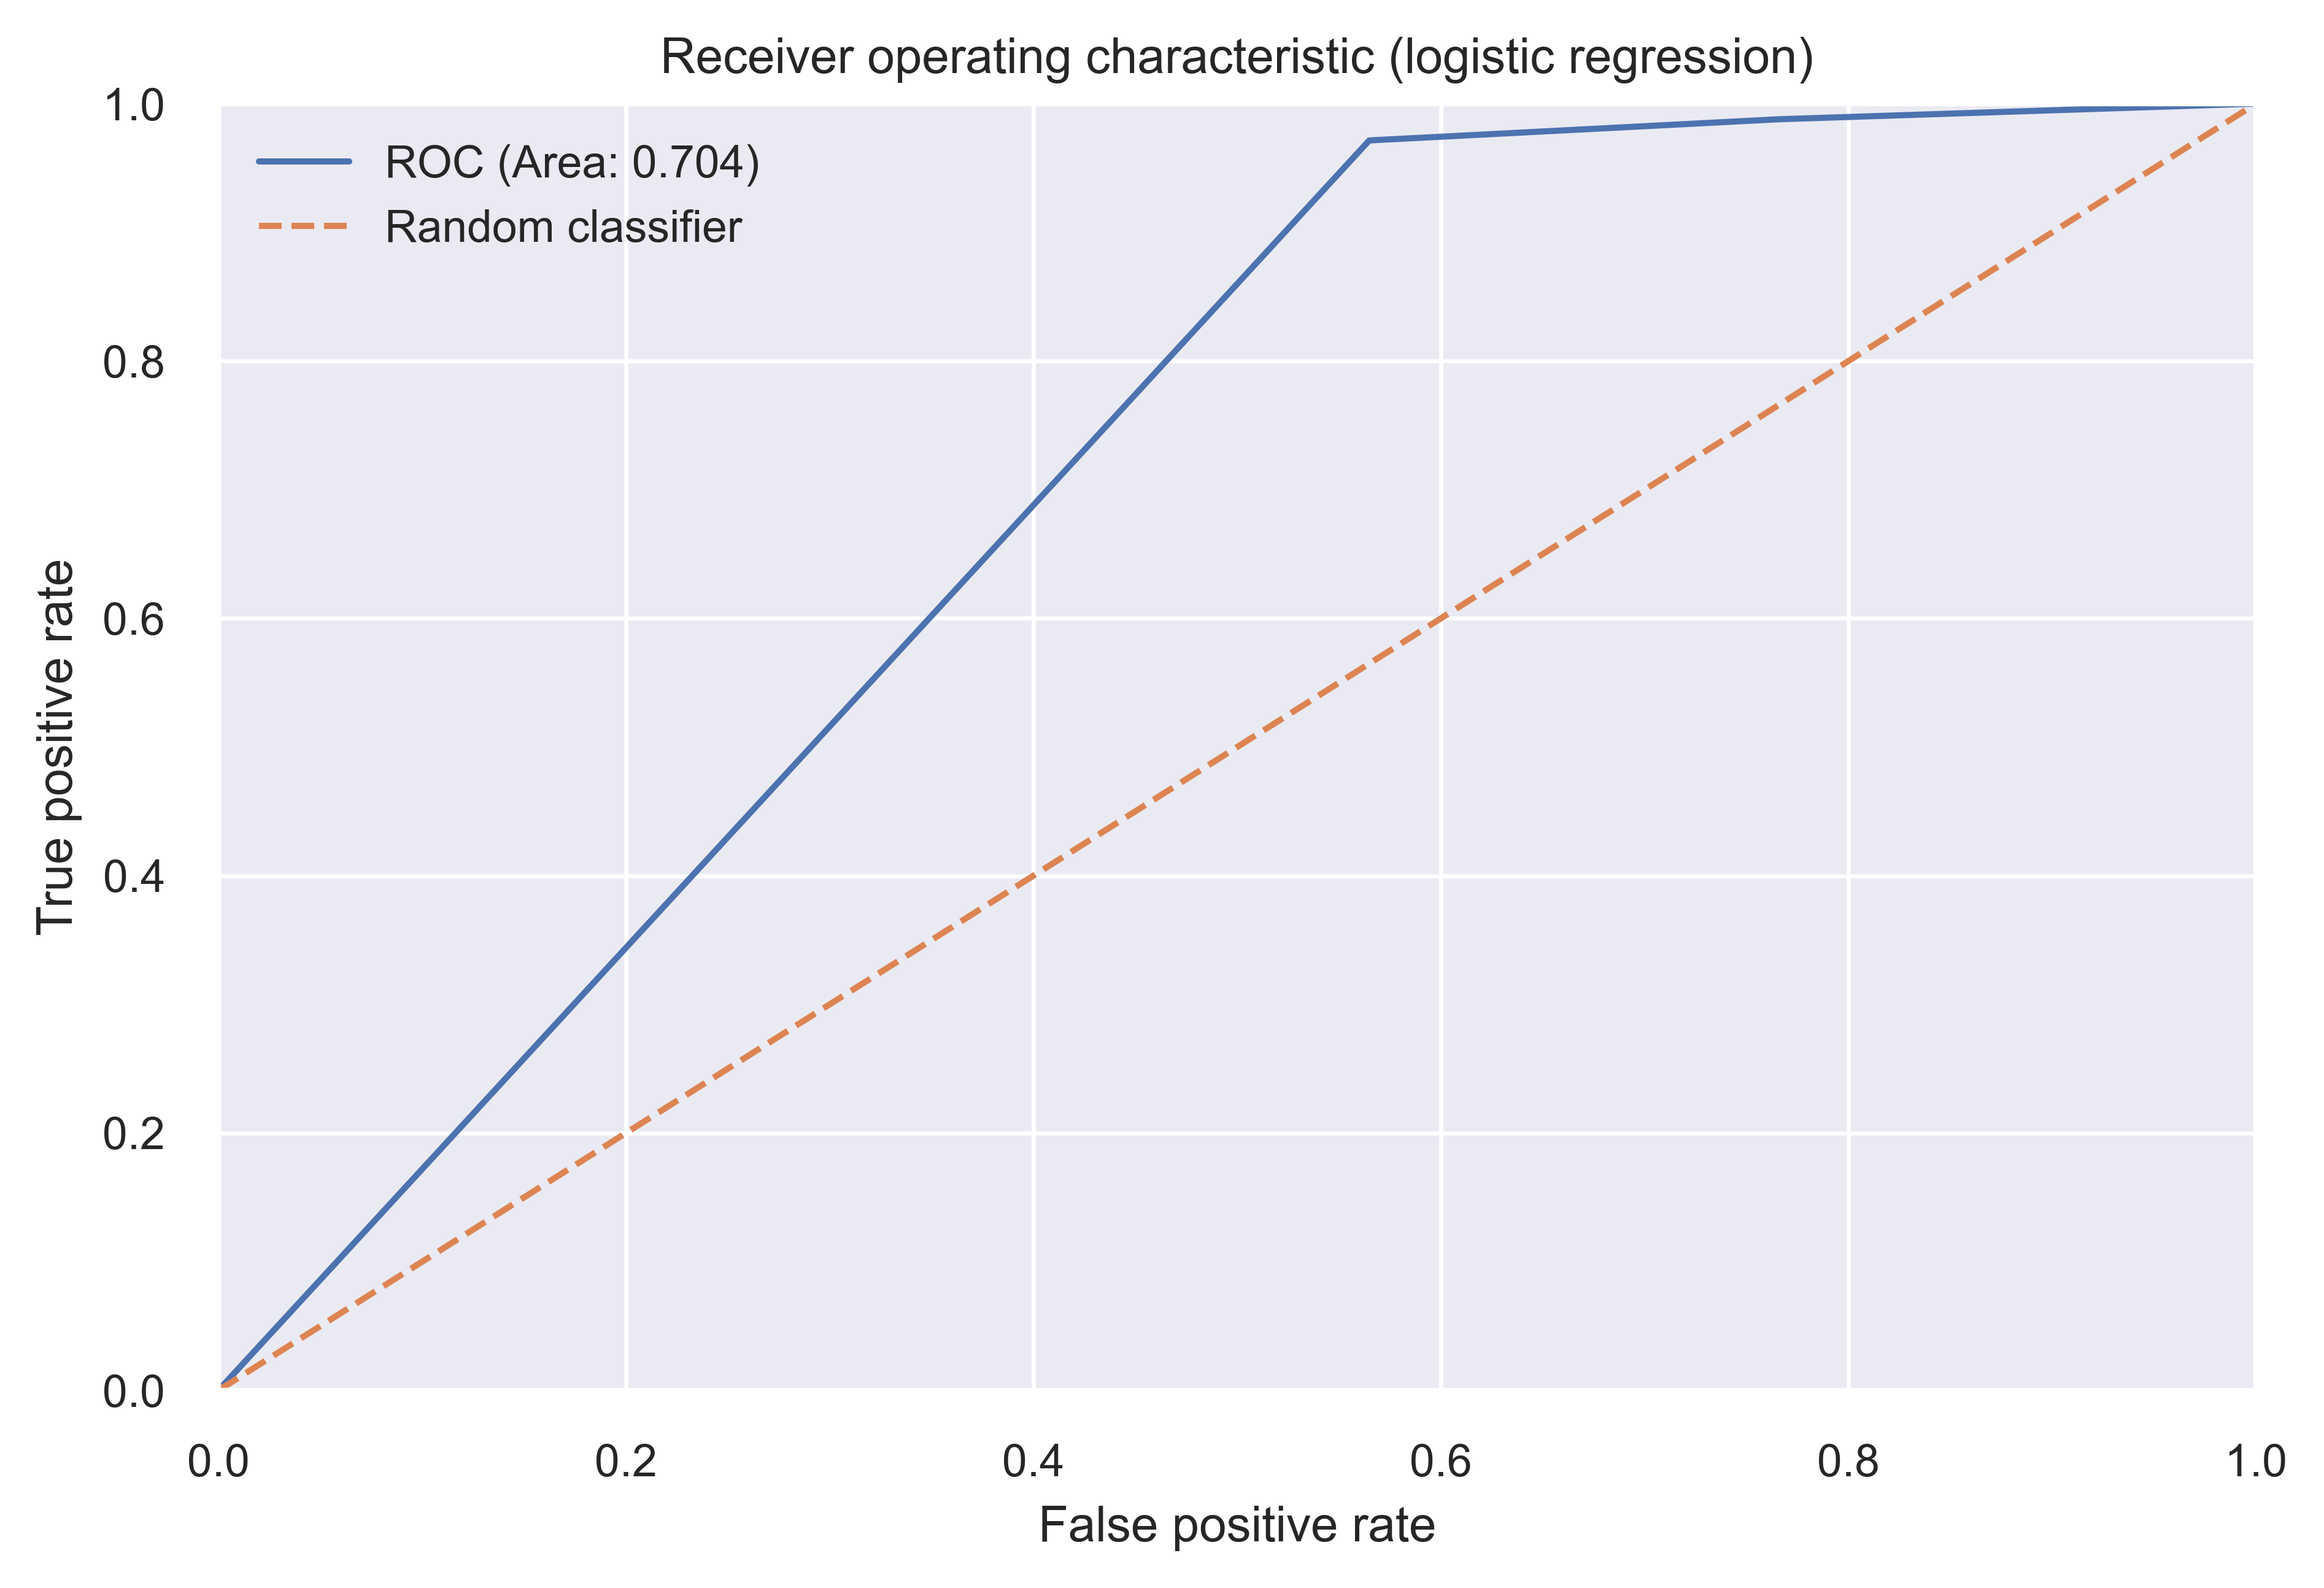

In [79]:
RESULTSDIR = os.path.join(
    os.path.abspath(os.path.dirname("")), "../results/rq3"
)


FALSE_POS_RATE, TRUE_POS_RATE, thresholds = roc_curve(
    ACTUALS, PREDS, pos_label=1
)
roc_auc = auc(FALSE_POS_RATE, TRUE_POS_RATE)

plt.plot(
    FALSE_POS_RATE,
    TRUE_POS_RATE,
    label=f"ROC (Area: {roc_auc:.3f})",
)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    label="Random classifier",
)

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(
    "Receiver operating characteristic (logistic regression)"
)
plt.legend(loc="best")
plt.savefig(os.path.join(RESULTSDIR, "logistic_roc.png"))
# plt.show()

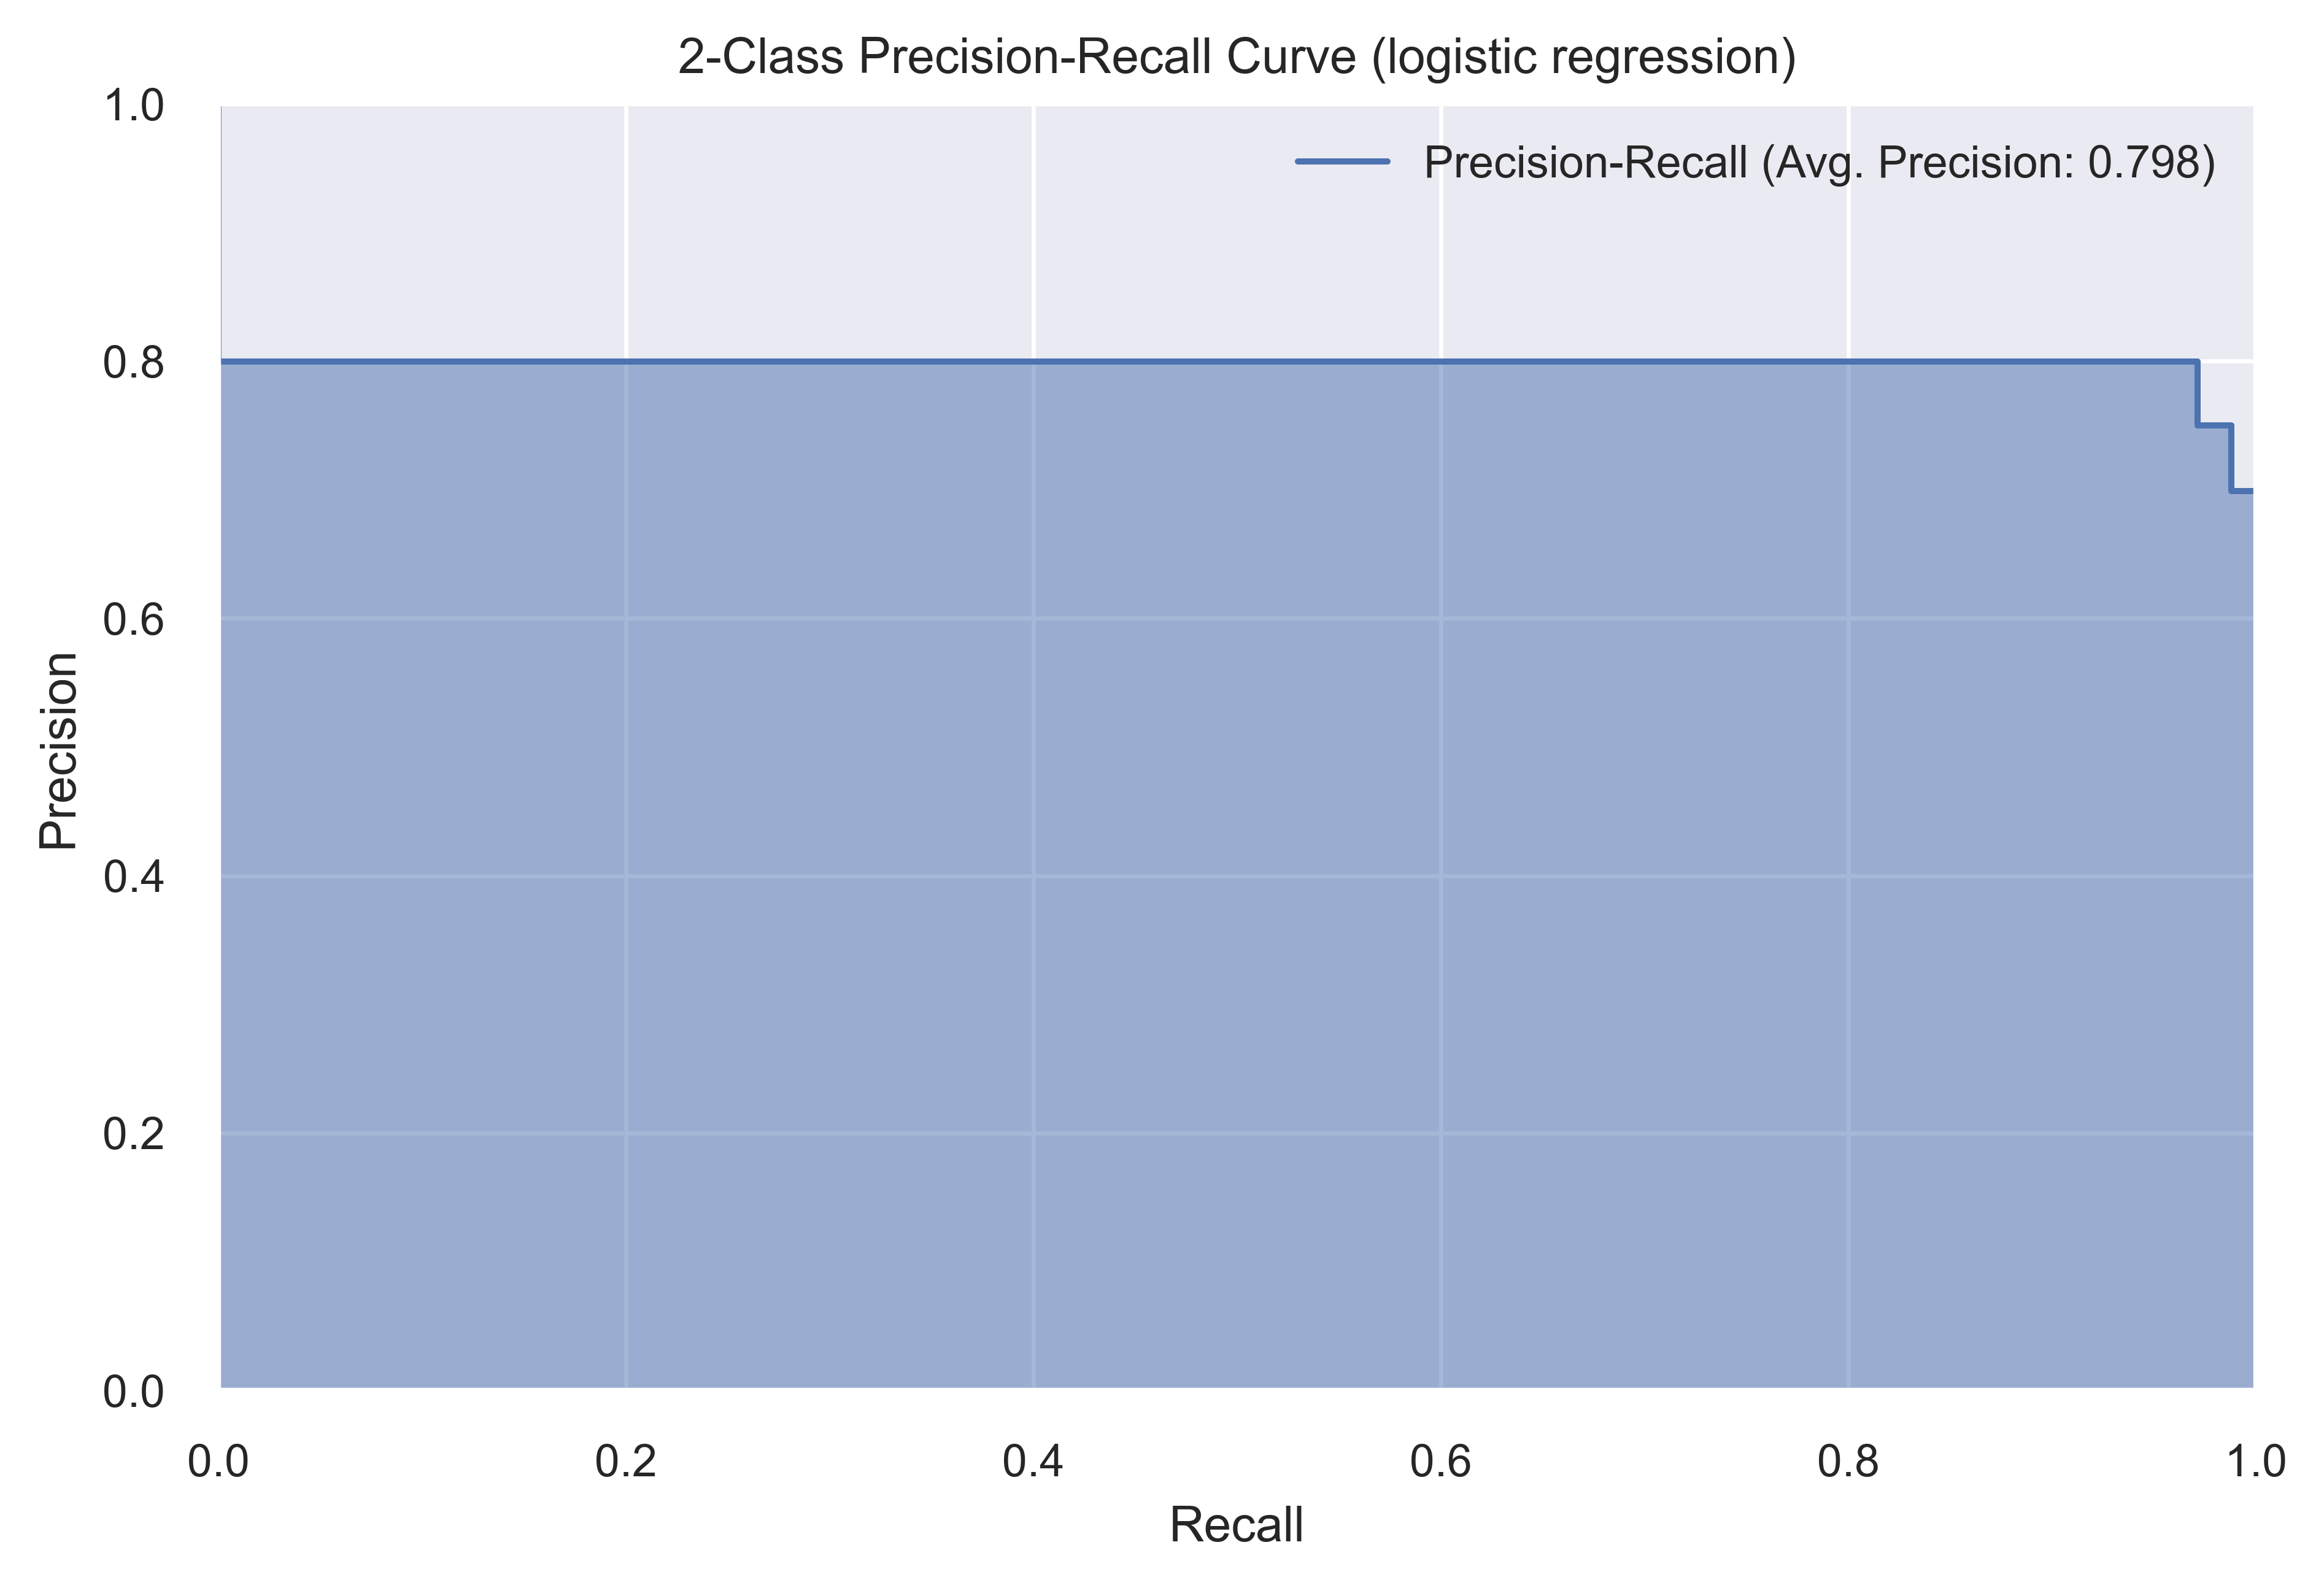

In [80]:
AVG_PRECISION = average_precision_score(
    ACTUALS, PREDS, pos_label=1
)
PRECISION, RECALL, _ = precision_recall_curve(
    ACTUALS, PREDS
)
step_kwargs = (
    {"step": "post"}
    if "step" in signature(plt.fill_between).parameters
    else {}
)

plt.step(
    RECALL,
    PRECISION,
    where="post",
    label=f"Precision-Recall (Avg. Precision: {AVG_PRECISION:.3f})",
)
plt.fill_between(
    RECALL, PRECISION, alpha=0.5, **step_kwargs
)
# plt.plot(RECALL, PRECISION, label=f"Precision-Recall")
# plt.plot(AVG_PRECISION, 0, label="Average")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.title(
    f"2-Class Precision-Recall Curve (logistic regression)"
)
plt.legend(loc="best")
plt.savefig(os.path.join(RESULTSDIR, "logistic_prc.png"))